# Behavioral Cloning
This notebook contains most of the code towards training a neural network to drive a car (determine steering angle) by  utilizing a convolutional neural network architecture. 

In [1]:
import csv
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.backend import clear_session
import h5py as h5py
import pickle
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers import Input
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras.backend
from keras.layers import Lambda
from keras.regularizers import l2
import scipy


clear_session()

%matplotlib inline

Using TensorFlow backend.


# Read the dataset

### Import the dataset
Before we can use the dataset,  we have to read it from the generated drives. For this purposes, a furnished dataset has been downloaded. UDacity provided this simple dataset, and it can be downloaded from [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

In [2]:
def import_dataset(data_source_path, csv_file_name):
    images = []
    steering_measurements = []
    throttle_measurements = []
    speed_measurements = []
    breaking_measurements = []
    with open(data_source_path+"./"+csv_file_name) as f:
        csv_lines = csv.reader(f)
        # skip first line
        next(csv_lines)
        for line in csv_lines:
            center, left, right, steering, throttle, br, speed = line
            steering = float(steering)
            for img_path, corrected_steering in zip([left, center, right], [steering+0.2, steering, steering-0.2]):
                image_path = img_path.strip()
                image = cv.imread(image_path)
                rgb = image[...,::-1]
                images.append(rgb)
                steering_measurements.append(corrected_steering)
                throttle_measurements.append(throttle)
                speed_measurements.append(speed)
                breaking_measurements.append(br)

    return np.array(images), np.array(steering_measurements), np.array(throttle_measurements), np.array(speed_measurements), np.array(breaking_measurements)

images, steering, throttle, speed, breaking = import_dataset('../ultimate_collection', 'driving_log.csv')

### Analyse the images
Now that we have the images, lets see their shape and see some samples.

In [3]:
print(sum([1 for image in images if image is None]))
print(sum([1 for image in images if image is not None]))
print(steering.shape)
print(images.shape)

0
20187
(20187,)
(20187, 160, 320, 3)


Number of images: 15174
Shape of each image: (160, 320, 3)
random sample of steering angles: [0.209389671, -0.061032870000000003, 0.03286385, 0.21408451000000001]
random sample of breaking: ['0', '0', '0', '0']
random sample of throttle: ['1', '1', '1', '1']
random sample of speed: ['30.1899', '6.834935', '30.18968', '30.19031']


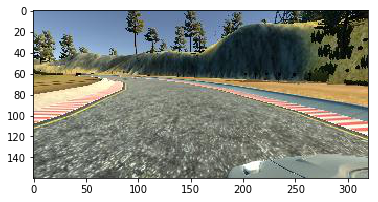

In [4]:
num_images, x_shape, y_shape, depth = images.shape
image_shape = (x_shape, y_shape, depth)
print("Number of images:", num_images)
print("Shape of each image:", image_shape)
print("random sample of steering angles:", random.sample(list(steering), 4))
print("random sample of breaking:", random.sample(list(breaking), 4))
print("random sample of throttle:", random.sample(list(throttle), 4))
print("random sample of speed:", random.sample(list(speed), 4))
plt.imshow(images[0])

# Training pipelines
To create a streamlined timeline, we create a generator that outputs images to the caller function in a loop but does not store the data, so each datapoint is evaluated on the fly. In this generator we do the follwowing:
- Read the left, center, and right images for each frame, and for each:
  - Resize the image
  - Apply steering correction
  - Create a mirror image with mirror steering
  - Add the mirror and original image and steering to the dataset to return

In [3]:
def generator(sample_lines, batch_size=32):
    num_samples = len(sample_lines)
    while 1: # Loop forever so the generator never terminates
        shuffle(sample_lines)
        images = []
        angles = []
        for offset in range(0, len(sample_lines), batch_size):
            batch_samples = sample_lines[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                for image_name, correction in zip(batch_sample[:1], [ 0]):
                    name = image_name.split('/')[-1]
                    center_image = cv.imread(name)
                    center_image = cv.resize(center_image, (160, 80))
                    center_image = cv.cvtColor(center_image, cv.COLOR_BGR2RGB)
    #                 print("size:",np.array(center_image).shape)
                    center_angle = float(batch_sample[3])+correction
                    images.append(center_image)
                    angles.append(center_angle)
                    images.append(np.fliplr(center_image))
                    angles.append(-1.*center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train


samples = []
with open('../ultimate_collection/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

In [5]:
def normalize(image):
    return image/255.0 - 0.5

def train_model():
    
    model = Sequential()
    model.add(Lambda(normalize, input_shape=(80, 160, 3)))
    
    model.add(Conv2D(24, (5,5), strides=(2,2), kernel_regularizer=l2(0.0005), activation='relu'))
    print(model.layers[-1].output_shape)
    
    model.add(Conv2D(36, (5,5), strides=(2,2), kernel_regularizer=l2(0.0005), activation='relu'))
    print(model.layers[-1].output_shape)
    
    
    model.add(Conv2D(48, (5,5), strides=(2,2), kernel_regularizer=l2(0.0005), activation='relu'))
    print(model.layers[-1].output_shape)
    
    model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.0005), activation='relu'))
    print(model.layers[-1].output_shape)
    
    
    model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.0005), activation='relu'))
    print(model.layers[-1].output_shape)
    
    model.add(Flatten())
    model.add(Dense(100, kernel_regularizer=None))
    model.add(Dense(50, kernel_regularizer=None))
    model.add(Dense(1, kernel_regularizer=None))
    model.compile(optimizer='adam', loss='mse')
    
    batch_size = 128
    steps_per_epoch = len(train_samples)//batch_size
    
    model.fit_generator(train_generator, epochs=15, steps_per_epoch = steps_per_epoch, \
                        validation_data=validation_generator, validation_steps=len(validation_samples)//batch_size, \
                        verbose=2)
    model.save("model.h5")


    

train_model()
clear_session()

(None, 38, 78, 24)
(None, 17, 37, 36)
(None, 7, 17, 48)
(None, 5, 15, 64)
(None, 3, 13, 64)
Epoch 1/15
7s - loss: 0.0564 - val_loss: 0.0318
Epoch 2/15
5s - loss: 0.0242 - val_loss: 0.0211
Epoch 3/15
5s - loss: 0.0179 - val_loss: 0.0224
Epoch 4/15
6s - loss: 0.0144 - val_loss: 0.0168
Epoch 5/15
7s - loss: 0.0139 - val_loss: 0.0125
Epoch 6/15
9s - loss: 0.0124 - val_loss: 0.0163
Epoch 7/15
8s - loss: 0.0128 - val_loss: 0.0145
Epoch 8/15
8s - loss: 0.0137 - val_loss: 0.0155
Epoch 9/15
8s - loss: 0.0107 - val_loss: 0.0145
Epoch 10/15
8s - loss: 0.0116 - val_loss: 0.0103
Epoch 11/15
8s - loss: 0.0113 - val_loss: 0.0148
Epoch 12/15
8s - loss: 0.0108 - val_loss: 0.0120
Epoch 13/15
8s - loss: 0.0106 - val_loss: 0.0103
Epoch 14/15
8s - loss: 0.0099 - val_loss: 0.0141
Epoch 15/15
8s - loss: 0.0103 - val_loss: 0.0142
